# HEART DISEASE PREDICTION USING RANDOM FOREST  

> **Objective:**  
Build a `Random Forest` classification model to predict heart disease using the Cleveland Clinical Dataset and evaluate its performance using key ML metrics.

## Introduction  

Machine Learning models — particularly tree-based methods like **Random Forest** — are powerful tools that identify patterns in patient data.

In this project, we will:  

- Perform EDA and preprocessing  
- Train a **Random Forest Classifier**  
- Tune hyperparameters (`n_estimators` and `max_depth`)  
- Evaluate using **Accuracy, Precision, Recall, ROC–AUC**  
- Analyze **Feature Importance**  


In [1]:
# Import required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")


### Verifying Dataset Shape and Columns  
Before proceeding, we confirm the number of samples, number of features, and the exact column names directly from the dataset.


In [2]:
# Load dataset
df = pd.read_csv("Heart_disease_cleveland_new.csv")  # Change filename if needed
df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,0,145,233,1,2,150,0,2.3,2,0,2,0
1,67,1,3,160,286,0,2,108,1,1.5,1,3,1,1
2,67,1,3,120,229,0,2,129,1,2.6,1,2,3,1
3,37,1,2,130,250,0,0,187,0,3.5,2,0,1,0
4,41,0,1,130,204,0,2,172,0,1.4,0,0,1,0


## Converting Numerical Gender Values to Labels

The dataset encodes gender as:
- `0` → female  
- `1` → male  

To make analyses and visualizations easier, we convert these numeric values into text labels.


In [3]:
# Convert sex values to numeric (in case they are strings)
df["sex"] = df["sex"].astype(int)

# Map 0/1 → female/male
df["sex"] = df["sex"].map({0: "female", 1: "male"})

df["sex"].unique(), df.head()


(array(['male', 'female'], dtype=object),
    age     sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
 0   63    male   0       145   233    1        2      150      0      2.3   
 1   67    male   3       160   286    0        2      108      1      1.5   
 2   67    male   3       120   229    0        2      129      1      2.6   
 3   37    male   2       130   250    0        0      187      0      3.5   
 4   41  female   1       130   204    0        2      172      0      1.4   
 
    slope  ca  thal  target  
 0      2   0     2       0  
 1      1   3     1       1  
 2      1   2     3       1  
 3      2   0     1       0  
 4      0   0     1       0  )

In [4]:
# Check number of samples (rows) and features (columns)
print("Dataset Shape:", df.shape)

# Display column names
print("\nColumn Names:")
print(df.columns.tolist())

# View data types
print("\nData Types:")
print(df.dtypes)


Dataset Shape: (303, 14)

Column Names:
['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

Data Types:
age           int64
sex          object
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object


## Dataset Description  

We use the **Cleveland Heart Disease Dataset**, which contains **303 samples** and **14 attributes**.

### **Features Overview**

| Feature | Description |
|---------|-------------|
| age | Age of the patient |
| sex | Gender (1 = male, 0 = female) |
| cp | Chest pain type |
| trestbps | Resting blood pressure |
| chol | Serum cholesterol (mg/dl) |
| fbs | Fasting blood sugar (> 120 mg/dl) |
| restecg | Resting electrocardiographic results |
| thalach | Maximum heart rate achieved |
| exang | Exercise-induced angina |
| oldpeak | ST depression induced by exercise |
| slope | Slope of the peak exercise ST segment |
| ca | Number of major vessels colored by fluoroscopy |
| thal | Thalassemia |
| target | **1 = disease, 0 = no disease** |


> The **target variable** is binary — perfect for classification!


## Initial Data Exploration  

We inspect:  
- Shape of dataset  
- Missing values  
- Basic statistics  


In [26]:
print("Shape of Data:", df.shape)
print("\nMissing Values:\n")
print(df.isnull().sum())
print("Count of '?' values per column")
print((df=='?').sum())

df.describe()


Shape of Data: (284, 19)

Missing Values:

age          0
trestbps     0
chol         0
fbs          0
thalach      0
exang        0
oldpeak      0
ca           0
target       0
sex_male     0
cp_1         0
cp_2         0
cp_3         0
restecg_1    0
restecg_2    0
slope_1      0
slope_2      0
thal_2       0
thal_3       0
dtype: int64
Count of '?' values per column
age          0
trestbps     0
chol         0
fbs          0
thalach      0
exang        0
oldpeak      0
ca           0
target       0
sex_male     0
cp_1         0
cp_2         0
cp_3         0
restecg_1    0
restecg_2    0
slope_1      0
slope_2      0
thal_2       0
thal_3       0
dtype: int64


,age,trestbps,chol,fbs,thalach,exang,oldpeak,ca,target
count,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000
mean,54.070423,129.982394,242.535211,0.140845,150.000000,0.316901,0.948592,0.637324,0.443662
std,9.118883,15.450927,44.730155,0.348476,22.660967,0.466090,1.026141,0.904727,0.497693
min,29.000000,94.000000,126.000000,0.000000,88.000000,0.000000,0.000000,0.000000,0.000000
25%,47.000000,120.000000,210.750000,0.000000,133.750000,0.000000,0.000000,0.000000,0.000000
50%,55.000000,130.000000,239.500000,0.000000,153.000000,0.000000,0.600000,0.000000,0.000000
75%,60.000000,140.000000,271.000000,0.000000,168.000000,1.000000,1.600000,1.000000,1.000000
max,77.000000,170.000000,360.000000,1.000000,202.000000,1.000000,4.000000,3.000000,1.000000


# Exploratory Data Analysis (EDA)

We begin by visualizing the target distribution, gender distribution, how heart disease varies by gender, feature distributions, correlations, and outliers.


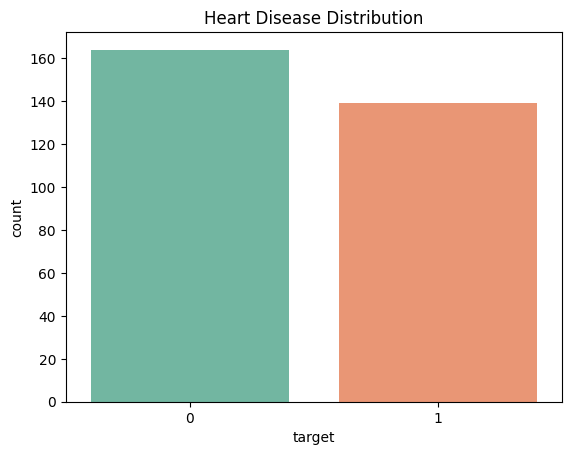

In [6]:
sns.countplot(x=df["target"], palette="Set2")
plt.title("Heart Disease Distribution")
plt.show()


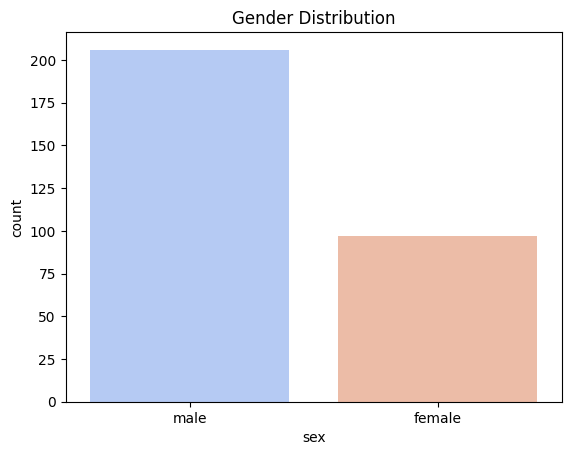

In [7]:
sns.countplot(x=df["sex"], palette="coolwarm")
plt.title("Gender Distribution")
plt.show()


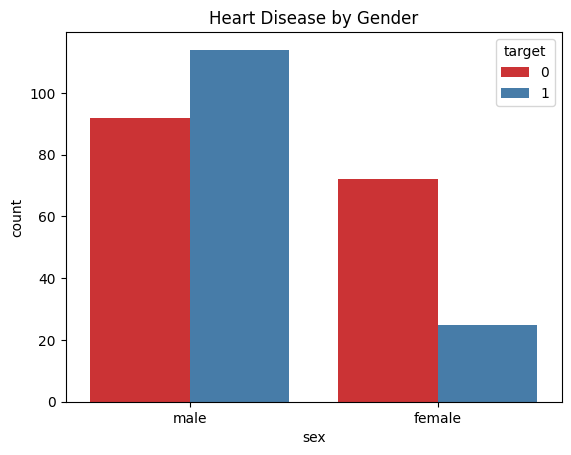

In [8]:
sns.countplot(x=df["sex"], hue=df["target"], palette="Set1")
plt.title("Heart Disease by Gender")
plt.show()


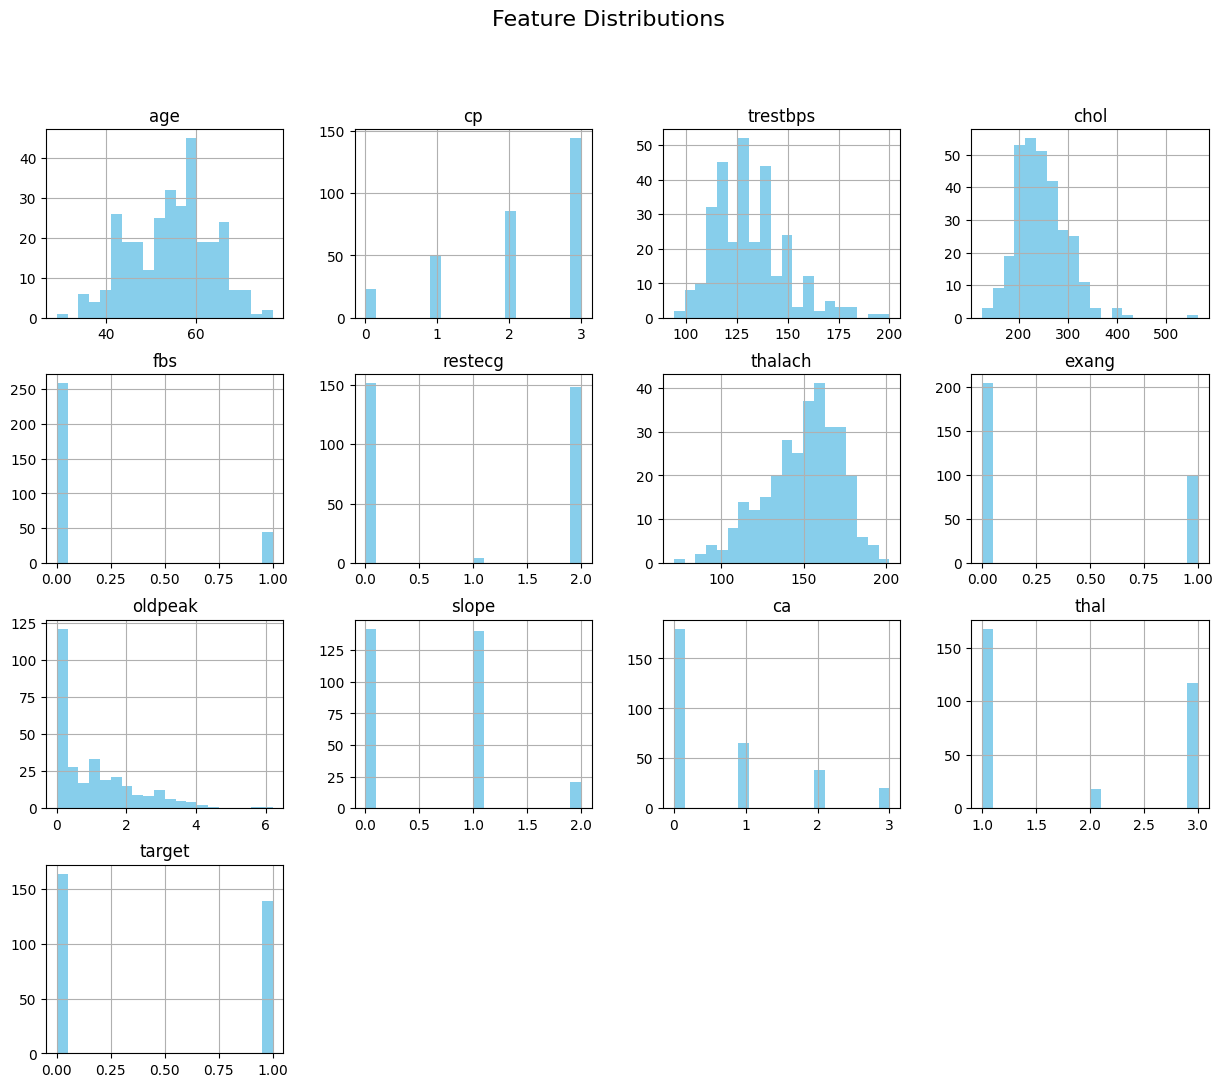

In [9]:
df.hist(figsize=(15, 12), bins=20, color="skyblue")
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()


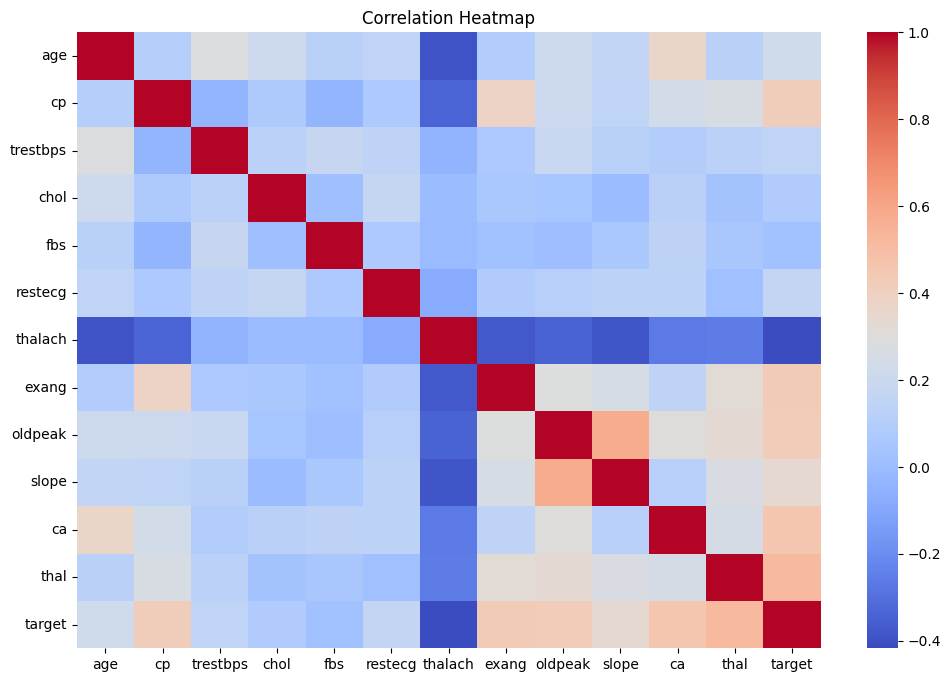

In [10]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include="number").corr(), cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


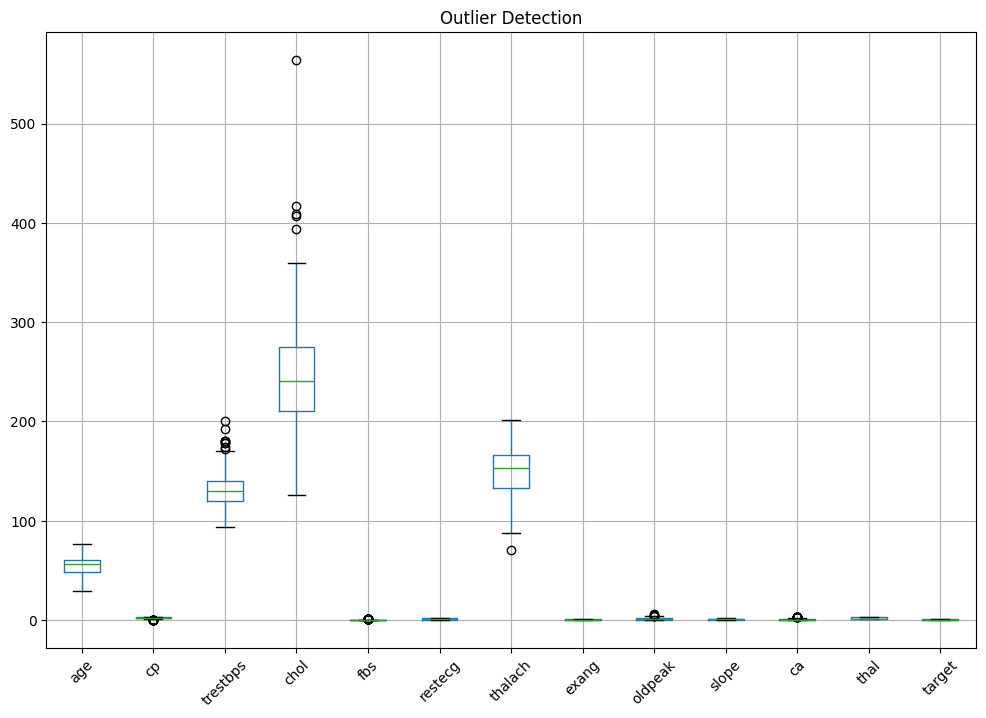

In [11]:
plt.figure(figsize=(12, 8))
df.select_dtypes(include="number").boxplot(rot=45)
plt.title("Outlier Detection")
plt.show()


## Outlier Removal (IQR Method)

Using the Interquartile Range (IQR) method, we remove extreme outliers from key numerical features to improve training quality.


In [12]:
def remove_outliers(df, cols):
    Q1 = df[cols].quantile(0.25)
    Q3 = df[cols].quantile(0.75)
    IQR = Q3 - Q1
    mask = ~((df[cols] < (Q1 - 1.5 * IQR)) | 
             (df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)
    return df[mask]

numeric_cols = ["age", "trestbps", "chol", "thalach", "oldpeak"]
df = remove_outliers(df, numeric_cols)

df.shape


(284, 14)

## One-Hot Encoding for Categorical Columns

We convert non-numeric categorical columns into dummy variables so that machine learning models can process them.


In [13]:
categorical_cols = ["sex", "cp", "restecg", "slope", "thal"]

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

df.head()


,age,trestbps,chol,fbs,thalach,exang,oldpeak,ca,target,sex_male,cp_1,cp_2,cp_3,restecg_1,restecg_2,slope_1,slope_2,thal_2,thal_3
0,63,145,233,1,150,0,2.3,0,0,True,False,False,False,False,True,False,True,True,False
1,67,160,286,0,108,1,1.5,3,1,True,False,False,True,False,True,True,False,False,False
2,67,120,229,0,129,1,2.6,2,1,True,False,False,True,False,True,True,False,False,True
3,37,130,250,0,187,0,3.5,0,0,True,False,True,False,False,False,False,True,False,False
4,41,130,204,0,172,0,1.4,0,0,False,True,False,False,False,True,False,False,False,False


## Data Preprocessing  

### Steps performed:
- Handle missing data  
- Split dataset into features and labels  
- Normalize numerical columns using **StandardScaler**  
- Create **train-test split (80–20)**  

> Good preprocessing ensures better model performance.


In [14]:
# Separate features and target
X = df.drop("target", axis=1)
y = df["target"]

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

X_train.shape, X_test.shape


((227, 18), (57, 18))

## Feature Scaling  

We scale numerical features using **StandardScaler** so all values are on a similar range.  


In [15]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Baseline Random Forest Model  

We begin by training a default Random Forest model to observe baseline performance.


In [16]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)

y_pred = rf.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))


Accuracy: 0.8596491228070176
Precision: 0.8260869565217391
Recall: 0.8260869565217391
ROC-AUC: 0.8542199488491048


## Hyperparameter Tuning  

We tune **two important parameters**:  
- `n_estimators` → number of trees  
- `max_depth` → depth of each tree  

Using **GridSearchCV (5-fold cross-validation)** ensures better generalization.


In [17]:
param_grid = {
    "n_estimators": [50, 100, 150, 200],
    "max_depth": [None, 5, 10, 15]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1
)

grid.fit(X_train_scaled, y_train)

print("Best Parameters:", grid.best_params_)

best_model = grid.best_estimator_


Best Parameters: {'max_depth': 5, 'n_estimators': 100}


## Model Evaluation  

We evaluate performance using:  
- Accuracy  
- Precision  
- Recall  
- ROC–AUC  
- Confusion Matrix  
- Classification Report  


In [18]:
y_pred_best = best_model.predict(X_test_scaled)
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("Precision:", precision_score(y_test, y_pred_best))
print("Recall:", recall_score(y_test, y_pred_best))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_best))


Accuracy: 0.8596491228070176
Precision: 0.8260869565217391
Recall: 0.8260869565217391
ROC-AUC: 0.9514066496163682

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.88      0.88        34
           1       0.83      0.83      0.83        23

    accuracy                           0.86        57
   macro avg       0.85      0.85      0.85        57
weighted avg       0.86      0.86      0.86        57



## Confusion Matrix  


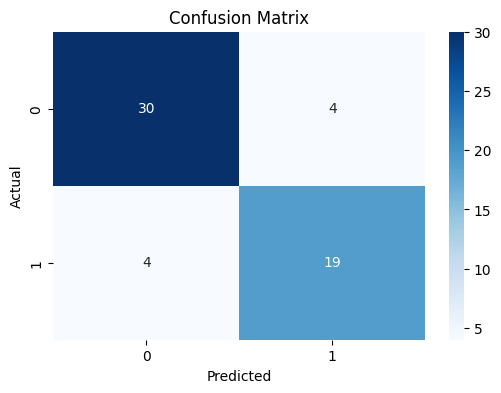

In [19]:
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## ROC Curve  


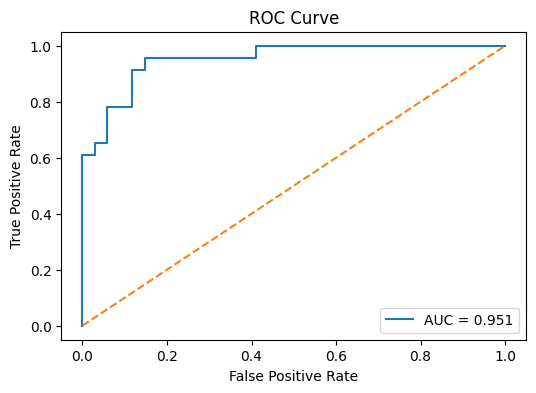

In [20]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


## Feature Importance Analysis  

We analyze which input features affect the model’s prediction the most.


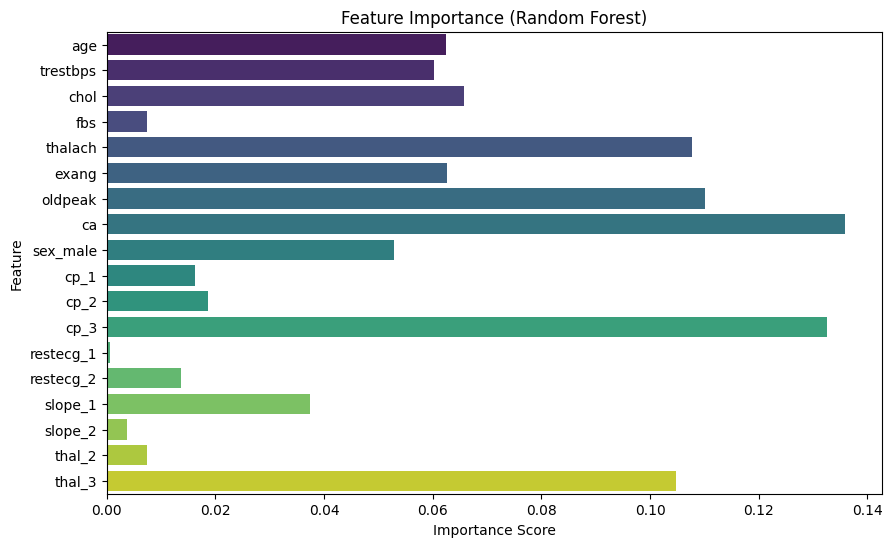

In [21]:
importances = best_model.feature_importances_
features = X.columns

plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=features, palette="viridis")
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


## Conclusion  

> **Random Forest achieved strong performance**  
> using medical attributes to predict heart disease.

### Key Takeaways:
- Hyperparameter tuning improved performance  
- ROC–AUC indicates the model is reliable  
- Important features include:  
  - **cp (chest pain type)**  
  - **thalach**  
  - **oldpeak**  
  - **ca**  
  - **thal**

### Final Statement  
The model is accurate, interpretable, and useful for clinical decision-support applications.

---
